## Test the performance with different flows

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils.metrics import  PIVmetric
from piv_onepass import piv_scc, piv_scc_min, piv_scc_lpf, piv_spof, piv_rpc, piv_sbcc

np.random.seed(202404)

In [2]:
# Basic functions and the compare cases
def read_flow(path):
    img1 = cv2.imread(path+"_img1.tif", 0)
    img2 = cv2.imread(path+"_img2.tif", 0)
    
    p_flow = path+"_flow.flo"
    flows = np.fromfile(p_flow, dtype=np.float32)
    vec = np.reshape(flows[3:], (256,256,2))
    u, v = vec[:,:,0], vec[:,:,1]
    u, v = np.mean(u), np.mean(v)
    return img1, img2, u, v

def sine_bg(sz):
    x, y = np.meshgrid(np.arange(sz[0]),np.arange(sz[1]), indexing="ij")
    theta = np.random.rand()*2*np.pi
    period = np.random.rand()*32+16
    phi0 = 2*np.random.rand()*np.pi
    bg = np.sin(2*np.pi*(x*np.cos(theta)+y*np.sin(theta))/period+phi0)

    B = np.random.rand()*64
    A = B+np.random.rand()*32
    bg = A+B*bg
    return bg

def square_bg(sz):
    bg = sine_bg(sz)
    mean = np.mean(bg)
    min = np.min(bg)
    bg = min+1.5*mean*(bg>mean)
    return bg

def exp3_onecase(img1, img2, ut, vt, show=True):        
    if show:
        plt.figure(figsize=(5,3))
        names = ["image1", "image2"]
        for k, img in enumerate([img1, img2]):
            plt.subplot(1,2,k+1)
            plt.imshow(img, cmap="gray")
            plt.axis("off")
            plt.title(names[k])
        plt.savefig("images.pdf")
        
    if show:
        plt.figure(figsize=(9,6))
        strs = [m.__name__ for m in [piv_scc, piv_scc_min, piv_scc_lpf, piv_spof, piv_rpc, piv_sbcc]]
        print(f"The results for {strs}")
    
    results =[]
    for k, m in enumerate([piv_scc, piv_scc_min, piv_scc_lpf, piv_spof, piv_rpc, piv_sbcc]):
        x1,y1,u1,v1 = m(img1, img2)
        if show:
            print(m.__name__+":")
        res = PIVmetric(ut+0*u1,vt+0*v1,u1,v1, show=show)
        results.append(res)
        if show:
            plt.subplot(2,3,k+1)
            plt.quiver(x1,y1,u1,v1) # Without any modification
            plt.title(m.__name__)
    if show:
        plt.show()
    return results

### 0. Test without additive background

The results for ['piv_scc', 'piv_scc_min', 'piv_scc_lpf', 'piv_spof', 'piv_rpc', 'piv_sbcc']
piv_scc:
0.3753(RMSE)	0.3422(AEE)	0.0438(AAE,rad)	0.2843(SSIM)	0.9459(MoC)	0(Outlier)	
piv_scc_min:
0.4422(RMSE)	0.3827(AEE)	0.0531(AAE,rad)	0.2141(SSIM)	0.9535(MoC)	1(Outlier)	
piv_scc_lpf:
0.3919(RMSE)	0.3438(AEE)	0.0441(AAE,rad)	0.1856(SSIM)	0.9515(MoC)	0(Outlier)	
piv_spof:
0.4060(RMSE)	0.3768(AEE)	0.0504(AAE,rad)	0.2709(SSIM)	0.9439(MoC)	0(Outlier)	
piv_rpc:
0.1883(RMSE)	0.1619(AEE)	0.0231(AAE,rad)	0.3639(SSIM)	0.9951(MoC)	0(Outlier)	
piv_sbcc:
0.2195(RMSE)	0.2050(AEE)	0.0221(AAE,rad)	0.4429(SSIM)	1.0324(MoC)	0(Outlier)	


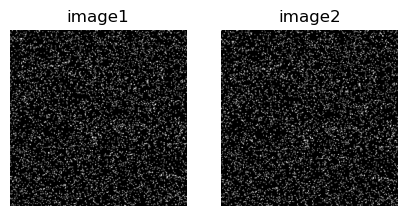

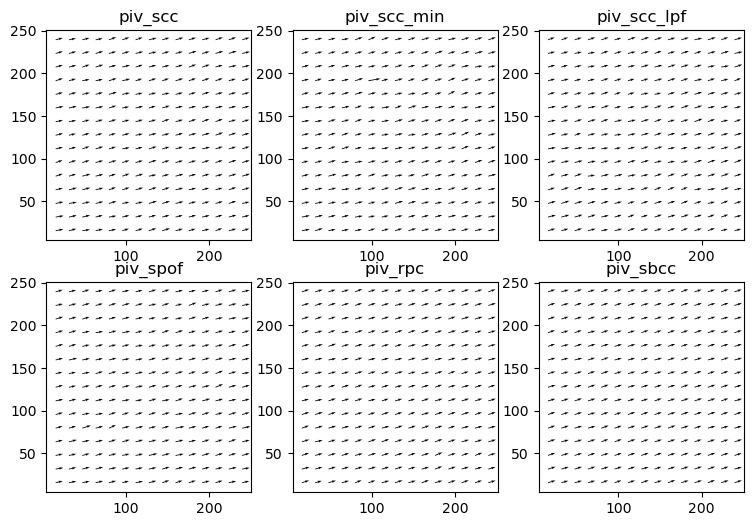

In [3]:
# Test without additive background
path = "./data/simulated/uniform/uniform_00011"
img1, img2, ut, vt = read_flow(path)
results = exp3_onecase(img1, img2, vt, ut)

### 1. Test with additive bubble background

The results for ['piv_scc', 'piv_scc_min', 'piv_scc_lpf', 'piv_spof', 'piv_rpc', 'piv_sbcc']
piv_scc:
0.5054(RMSE)	0.4557(AEE)	0.0467(AAE,rad)	0.2216(SSIM)	0.9173(MoC)	0(Outlier)	
piv_scc_min:
0.4422(RMSE)	0.3827(AEE)	0.0531(AAE,rad)	0.2141(SSIM)	0.9535(MoC)	1(Outlier)	
piv_scc_lpf:
0.3487(RMSE)	0.3213(AEE)	0.0405(AAE,rad)	0.3611(SSIM)	0.9506(MoC)	0(Outlier)	
piv_spof:
0.4530(RMSE)	0.4181(AEE)	0.0469(AAE,rad)	0.2485(SSIM)	0.9286(MoC)	0(Outlier)	
piv_rpc:
0.6597(RMSE)	0.4193(AEE)	0.0532(AAE,rad)	0.1822(SSIM)	0.9305(MoC)	3(Outlier)	
piv_sbcc:
0.2765(RMSE)	0.2457(AEE)	0.0328(AAE,rad)	0.2679(SSIM)	1.0021(MoC)	0(Outlier)	


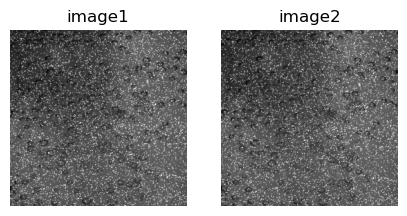

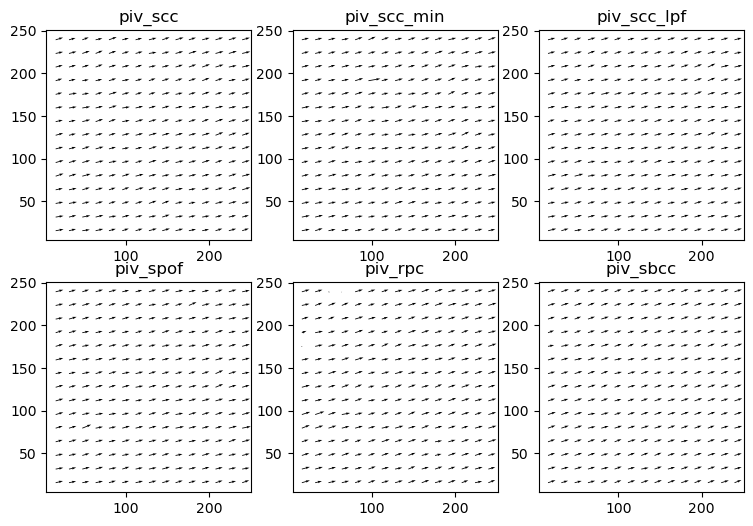

In [4]:
# Test with additive bubble background
path_bg = r"./data/simulated/bubbles/Class_1/13790.jpg"
bg = cv2.imread(path_bg,0)
bg = cv2.resize(bg, img1.shape)

path = "./data/simulated/uniform/uniform_00011"
img1, img2, ut,vt = read_flow(path)

img1_ = 0.5*img1+0.5*bg
img2_ = 0.5*img2+0.5*bg

results = exp3_onecase(img1_, img2_, vt, ut)

### 2. Test with additive sine background

The results for ['piv_scc', 'piv_scc_min', 'piv_scc_lpf', 'piv_spof', 'piv_rpc', 'piv_sbcc']
piv_scc:
0.7930(RMSE)	0.7813(AEE)	0.0380(AAE,rad)	0.4109(SSIM)	0.8322(MoC)	0(Outlier)	
piv_scc_min:
0.4422(RMSE)	0.3827(AEE)	0.0531(AAE,rad)	0.2141(SSIM)	0.9535(MoC)	1(Outlier)	
piv_scc_lpf:
0.3934(RMSE)	0.3721(AEE)	0.0370(AAE,rad)	0.4060(SSIM)	0.9297(MoC)	0(Outlier)	
piv_spof:
0.4725(RMSE)	0.4460(AEE)	0.0413(AAE,rad)	0.2893(SSIM)	0.9146(MoC)	0(Outlier)	
piv_rpc:
0.3724(RMSE)	0.3440(AEE)	0.0334(AAE,rad)	0.2799(SSIM)	0.9355(MoC)	0(Outlier)	
piv_sbcc:
0.1914(RMSE)	0.1741(AEE)	0.0250(AAE,rad)	0.3847(SSIM)	1.0057(MoC)	0(Outlier)	


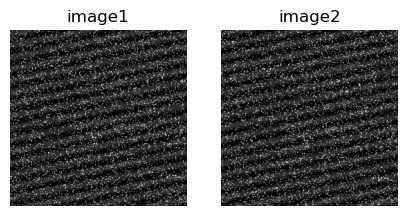

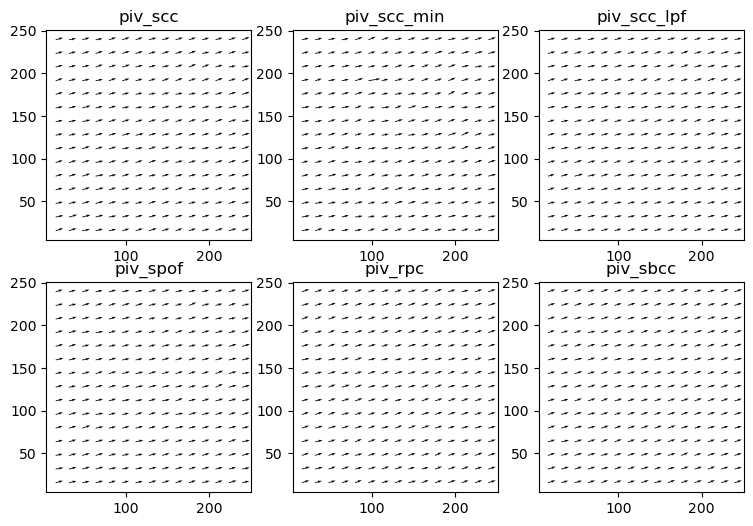

In [5]:
# Test with additive sine background
bg = sine_bg(img1.shape)

path = "./data/simulated/uniform/uniform_00011"
img1, img2, ut,vt = read_flow(path)

img1_ = 0.5*img1+0.5*bg
img2_ = 0.5*img2+0.5*bg

results = exp3_onecase(img1_, img2_, vt, ut)

### 3. Test with additive square background

The results for ['piv_scc', 'piv_scc_min', 'piv_scc_lpf', 'piv_spof', 'piv_rpc', 'piv_sbcc']
piv_scc:
0.4644(RMSE)	0.4311(AEE)	0.0358(AAE,rad)	0.2913(SSIM)	0.9148(MoC)	0(Outlier)	
piv_scc_min:
0.4422(RMSE)	0.3827(AEE)	0.0531(AAE,rad)	0.2141(SSIM)	0.9535(MoC)	1(Outlier)	
piv_scc_lpf:
0.3244(RMSE)	0.3054(AEE)	0.0398(AAE,rad)	0.4431(SSIM)	0.9517(MoC)	0(Outlier)	
piv_spof:
0.4382(RMSE)	0.4099(AEE)	0.0480(AAE,rad)	0.2611(SSIM)	0.9323(MoC)	0(Outlier)	
piv_rpc:
0.2274(RMSE)	0.1983(AEE)	0.0241(AAE,rad)	0.3381(SSIM)	0.9797(MoC)	0(Outlier)	
piv_sbcc:
0.1985(RMSE)	0.1810(AEE)	0.0246(AAE,rad)	0.4053(SSIM)	1.0165(MoC)	0(Outlier)	


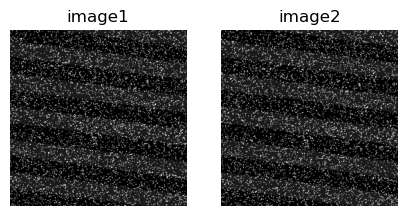

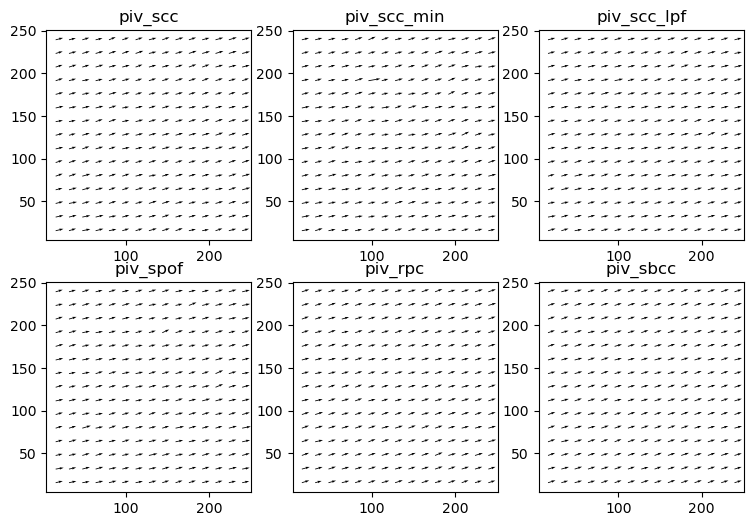

In [6]:
# Test with additive square background
bg = square_bg(img1.shape)

path = "./data/simulated/uniform/uniform_00011"
img1, img2, ut,vt = read_flow(path)

img1_ = 0.5*img1+0.5*bg
img2_ = 0.5*img2+0.5*bg

results = exp3_onecase(img1_, img2_, vt, ut)

### Test for the whole dataset

100%|███████████████████████████████████████████████████████████████| 1000/1000 [02:48<00:00,  5.95it/s]


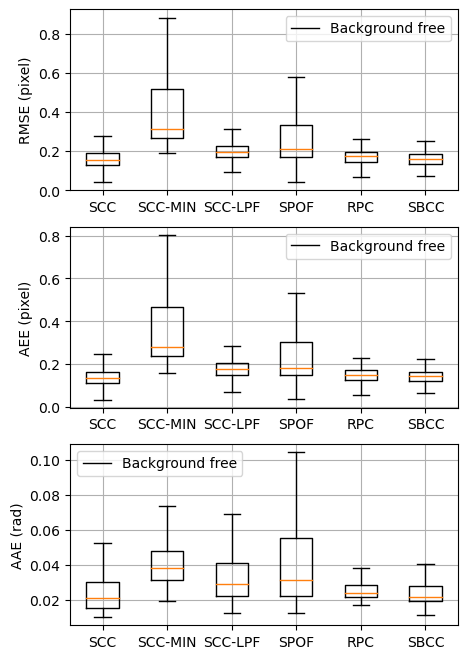

In [7]:
# Num=1001
Num=101 # Less data for test 

names = ["RMSE (pixel)","AEE (pixel)","AAE (rad)","SSIM", "MoC", "Outlier (100%)"]

results = []
for num in tqdm(range(1,Num)):
    path = f"./data/simulated/uniform/uniform_{num:05d}"
    img1, img2, ut,vt = read_flow(path)
    
    res = exp3_onecase(img1, img2, vt, ut, show=False)
    results.append(res)
    
results1 = np.array(results)
fig, ax = plt.subplots(3,1, figsize=(5, 8)) 
for i in range(3):
    ax[i].boxplot(results1[:,:,i], showfliers=False)
    ax[i].set_xticks([1,2,3,4,5,6],["SCC","SCC-MIN","SCC-LPF","SPOF","RPC","SBCC"])
    ax[i].set_ylabel(names[i])
    ax[i].legend(["Background free"])
    ax[i].grid("on")
plt.show()

100%|███████████████████████████████████████████████████████████████| 1000/1000 [02:37<00:00,  6.37it/s]


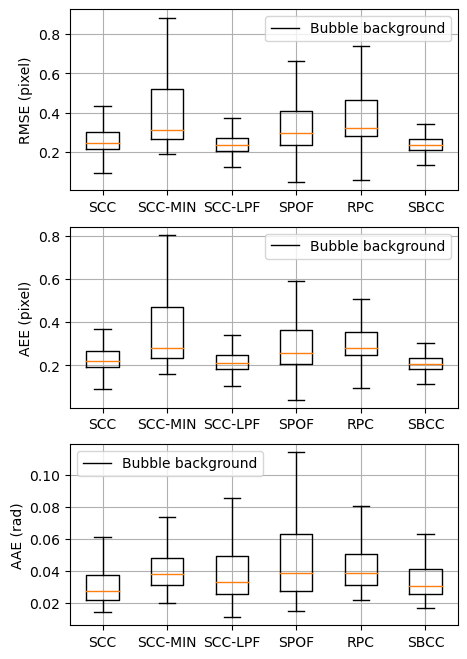

In [8]:
bg_list = os.listdir("./data/simulated/bubbles/Class_1/")

results = []
for num in tqdm(range(1,Num)):
    path = f"./data/simulated/uniform/uniform_{num:05d}"
    img1, img2, ut,vt = read_flow(path)
    
    path_bg = "./data/simulated/bubbles/Class_1/"+np.random.choice(bg_list)
    bg = cv2.imread(path_bg,0)
    bg = cv2.resize(bg, img1.shape)

    img1_ = 0.5*img1+0.5*bg
    img2_ = 0.5*img2+0.5*bg

    res = exp3_onecase(img1_, img2_, vt, ut, show=False)
    results.append(res)
    
results2 = np.array(results)
fig, ax = plt.subplots(3,1, figsize=(5, 8)) 
for i in range(3):
    ax[i].boxplot(results2[:,:,i], showfliers=False)
    ax[i].set_xticks([1,2,3,4,5,6],["SCC","SCC-MIN","SCC-LPF","SPOF","RPC","SBCC"])
    ax[i].set_ylabel(names[i])
    ax[i].legend(["Bubble background"])
    ax[i].grid("on")
plt.show()

100%|███████████████████████████████████████████████████████████████| 1000/1000 [02:40<00:00,  6.25it/s]


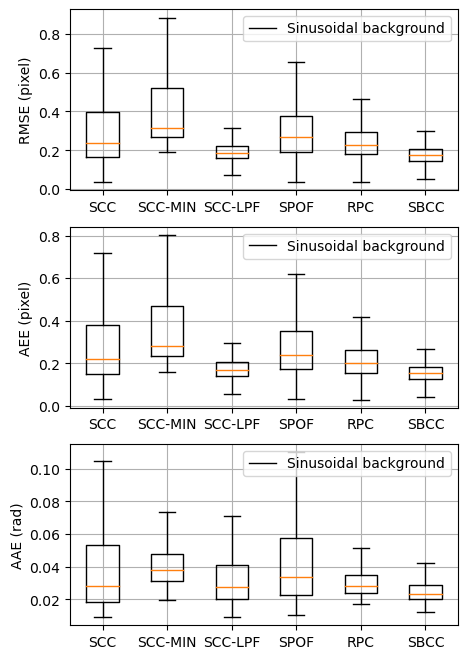

In [9]:
results = []
for num in tqdm(range(1,Num)):
    path = f"./data/simulated/uniform/uniform_{num:05d}"
    img1, img2, ut,vt = read_flow(path)
    bg = sine_bg(img1.shape)

    img1_ = 0.5*img1+0.5*bg
    img2_ = 0.5*img2+0.5*bg
    res = exp3_onecase(img1_, img2_, vt, ut, show=False)
    results.append(res)
    
results3 = np.array(results)
fig, ax = plt.subplots(3,1, figsize=(5, 8)) 
for i in range(3):
    ax[i].boxplot(results3[:,:,i], showfliers=False)
    ax[i].set_xticks([1,2,3,4,5,6],["SCC","SCC-MIN","SCC-LPF","SPOF","RPC","SBCC"])
    ax[i].set_ylabel(names[i])
    ax[i].grid("on")
    ax[i].legend(["Sinusoidal background"])
plt.show()

100%|███████████████████████████████████████████████████████████████| 1000/1000 [02:38<00:00,  6.32it/s]


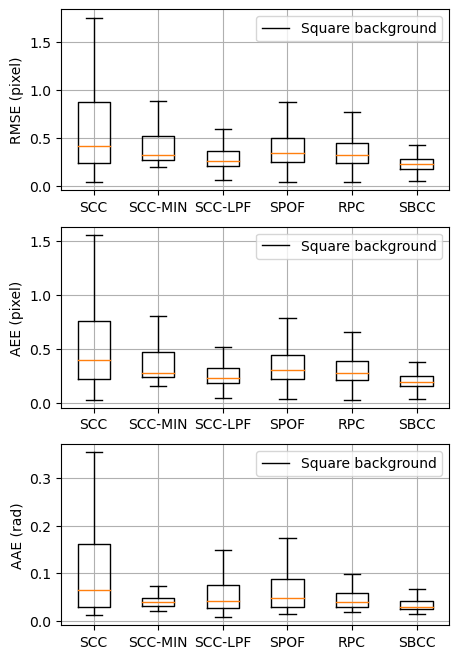

In [10]:
results = []
for num in tqdm(range(1,Num)):
    path = f"./data/simulated/uniform/uniform_{num:05d}"
    img1, img2, ut,vt = read_flow(path)
    
    bg = square_bg(img1.shape)
    img1_ = 0.5*img1+0.5*bg
    img2_ = 0.5*img2+0.5*bg
    res = exp3_onecase(img1_, img2_, vt, ut, show=False)
    results.append(res)
    
results4 = np.array(results)
fig, ax = plt.subplots(3,1, figsize=(5, 8)) 
for i in range(3):
    ax[i].boxplot(results4[:,:,i], showfliers=False)
    ax[i].set_xticks([1,2,3,4,5,6],["SCC","SCC-MIN","SCC-LPF","SPOF","RPC","SBCC"])
    ax[i].set_ylabel(names[i])
    ax[i].legend(["Square background"])
    ax[i].grid("on")
plt.show()

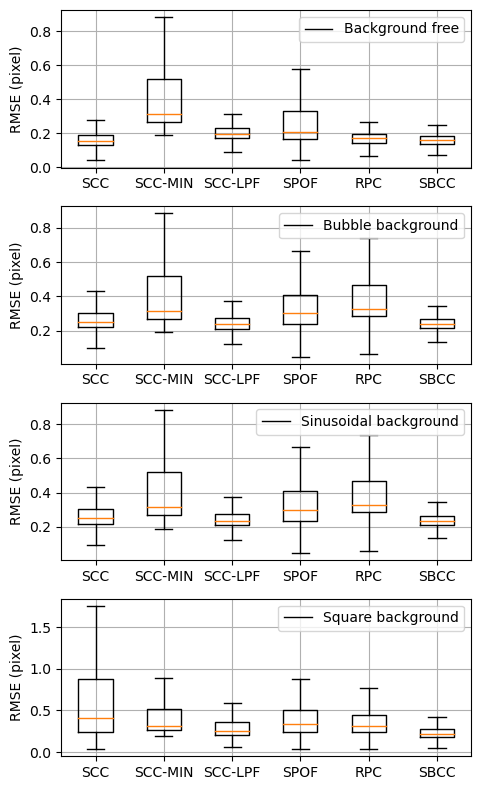

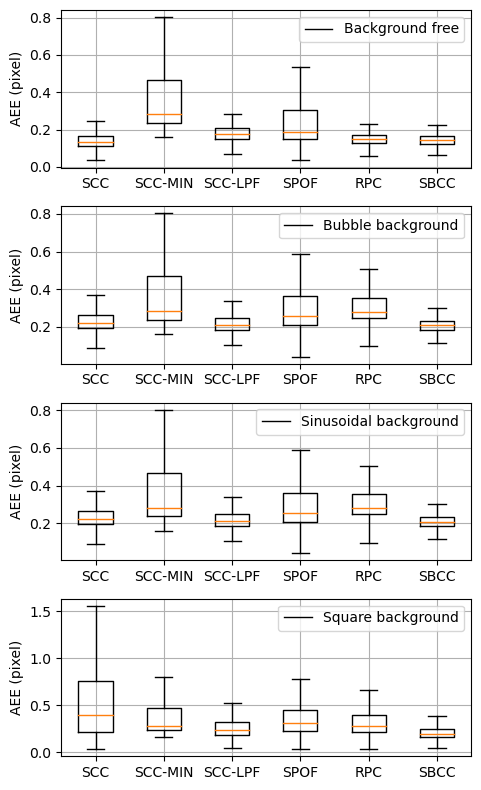

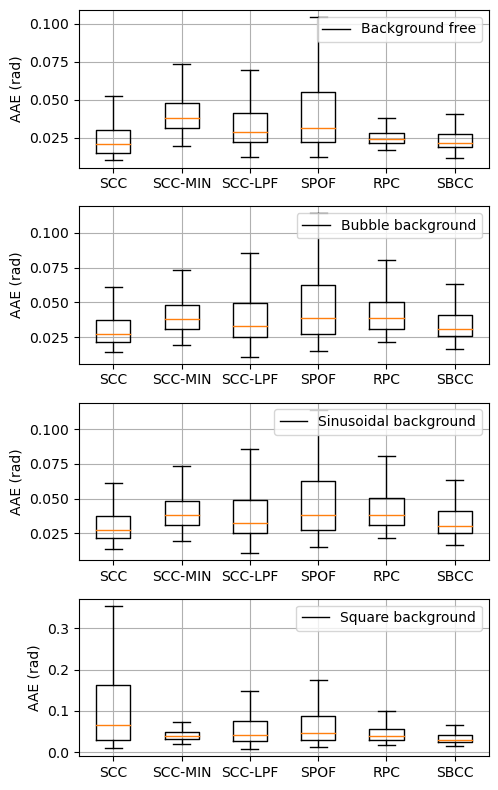

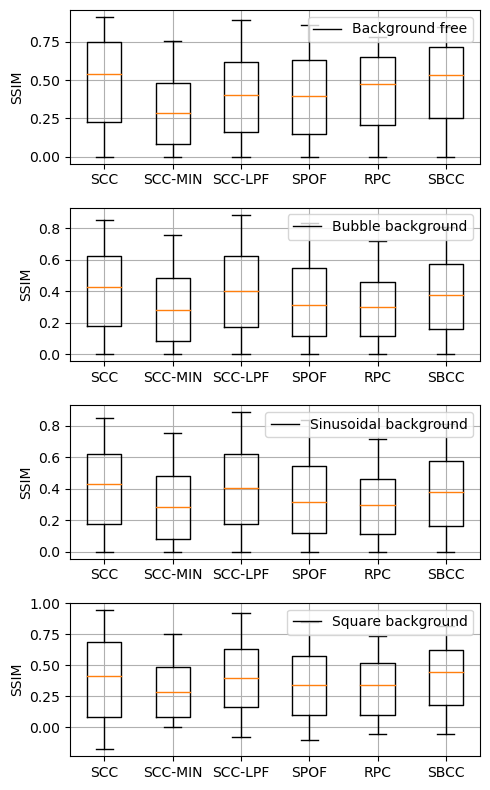

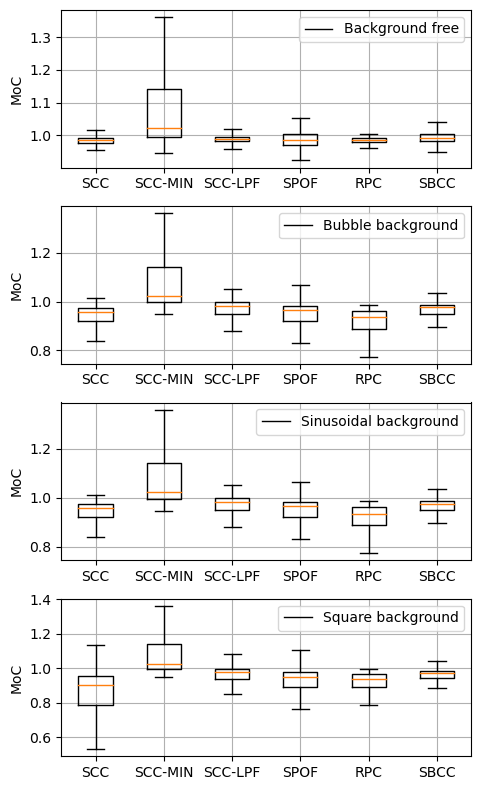

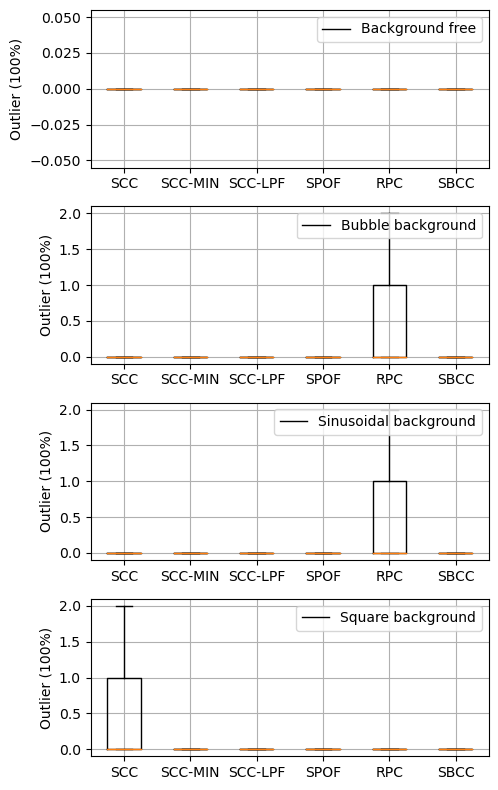

In [11]:
names = ["RMSE (pixel)","AEE (pixel)","AAE (rad)","SSIM", "MoC", "Outlier (100%)"]
legends = ["Background free","Bubble background","Sinusoidal background","Square background"]

for k in range(6):
    fig, ax = plt.subplots(4,1, figsize=(5, 8)) 
    for i, result in enumerate([results1, results2, results2,results4]):
        ax[i].boxplot(result[:,:,k], showfliers=False)
        ax[i].set_xticks([1,2,3,4,5,6],["SCC","SCC-MIN","SCC-LPF","SPOF","RPC","SBCC"])
        ax[i].set_ylabel(names[k])
        ax[i].legend([legends[i]], loc=1)
        ax[i].grid("on")
    plt.tight_layout()
    plt.savefig(f"./data/output/Fig9_{k}.pdf")
plt.show()

In [12]:
# T tests for the results
from scipy.stats import ttest_ind, ttest_rel

# p values for RMSE
for k, result in enumerate([results1, results2, results3,results4]):
    print(legends[k])
    for ind in range(6):
        # res = ttest_ind(result[:,ind,0],result[:,-1,0],alternative='greater')
        res = ttest_rel(result[:,ind,0],result[:,-1,0],alternative='greater')
        print(f"{res.pvalue:.4g}")

Background free
1.4e-05
8.75e-40
8.417e-157
6.266e-138
4.978e-39
nan
Bubble background
6.182e-26
1.519e-23
0.211
9.374e-71
1.347e-87
nan
Sinusoidal background
8.33e-25
2.654e-36
2.234e-31
4.373e-137
1.906e-46
nan
Square background
1.373e-54
1.655e-18
7.562e-06
2.9e-14
3.981e-47
nan


In [13]:
# p values for AEE
for k, result in enumerate([results1, results2, results3,results4]):
    print(legends[k])
    for ind in range(6):
        res = ttest_rel(result[:,ind,1],result[:,-1,1],alternative='greater')
        print(f"{res.pvalue:.4g}")

Background free
0.0001882
1.554e-72
1.175e-167
2.315e-132
1.83e-20
nan
Bubble background
4.286e-41
2.18e-47
1.772e-14
1e-96
2.761e-132
nan
Sinusoidal background
1.617e-27
2.511e-66
1.627e-36
3.638e-135
1.079e-86
nan
Square background
2.222e-53
3.692e-38
9.119e-09
8.45e-33
2.987e-38
nan
